# NMF Topic Modeling

In [130]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import gensim
import time

from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models.coherencemodel import CoherenceModel

from sklearn.linear_model import LinearRegression as lm

import matplotlib.collections as mcol
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from matplotlib.lines import Line2D

import seaborn as sns

In [66]:
#TODO:Input a dataframe that are ai related abstracts, need variables: final_frqwds_removed
abstracts = pd.read_csv(r'/home/zz3hs/git/dspg21RnD/data/dspg21RnD/new_matched_ai_abstracts.csv') 

In [4]:
abstracts.head()

(7933, 38)

# Coherence Model to find the optimal number of topics for NMF

In [5]:
def createVars(docs):

    # Create the variables needed for NMF from df[final_frqwds_removed]: dictionary (id2word), corpus
    
    # Create Dictionary
    id2word = gensim.corpora.Dictionary(docs)

    if len(docs) <= 100000:
        id2word.filter_extremes(no_below=3, no_above=1.0,  keep_n = 100000)
        print("Use keep_n = 100,000 defalt.")
    else:
        id2word.filter_extremes(no_below=3, no_above=1.0,  keep_n = len(docs))
        print("Number of documents exceed the dafalt number of 100,000. Use the keep_n = number of document.")

    # Create Corpus (Term Document Frequency)

    #Creates a count for each unique word appearing in the document, where the word_id is substituted for the word
    corpus = [id2word.doc2bow(doc) for doc in docs]

    return id2word, corpus

In [6]:
docs = abstracts["final_frqwds_removed"]

In [ ]:
clean_docs = []
for doc in docs:
    doc.replace("'", "")
    doc.replace("[", "")
    doc.replace("]", "")
    doc.split(',')
    clean_docs.append(doc)

In [43]:
import ast
clean_docs = []
for doc in docs:
    doc = ast.literal_eval(doc)
    clean_docs.append(doc)

In [46]:
#TODO: run the following code to generate id2word and corpus
#id2word, corpus = createVars(clean_docs)

#TODO: RENAME the file, run the code to save the output
#pickle.dump([corpus, id2word, clean_docs], open('../../data/dspg21RnD/coherence_vars_OECD.sav','wb'))

Use keep_n = 100,000 defalt.


# Read in Coherence file

In [47]:
#TODO: Read in your coherence data (change the name of the file)
f = open('../../data/dspg21RnD/coherence_vars_OECD.sav', 'rb')
[corpus, id2word, docs] = pickle.load(f)
f.close()

In [49]:
text = []

for abstract in docs:
    text.append(" ".join(abstract))

In [50]:
text[0]

'bring strong interdisciplinary team powerful image processing database exponentially grow bio_molecular image enable generation bio_image informatic contemporary microscopic immunofluorescence_microscopy electron_microscopy gfp visualization atomic force microscopy enormously molecular cell biology individual lab generate thousand image weekly unfortunately image analyze label archive manually vast_majority image publish fact valuable inherent manual labeling archiving lack central searchable repository image sort analogous dna sequence database impediment progress essentially general description molecular cellular biology represent impediment progress emerge bio image informatic organizing processing urgently_need couple recent advance image processing pattern recognition mining enormous generate bio molecular imaging progress cellular subcelluar sttr effor technology transfer commericialization bring scientist desktop powerful image informatic easily accesible expect facilitate rapi

In [51]:
# function slightly modified from https://nlpforhackers.io/topic-modeling/

def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):  # loop through each row of H.  idx = row index.  topic = actual row
        print("\nTopic %d:" % (idx))
        #print([(vectorizer.get_feature_names()[i], topic[i])  # printing out words corresponding to indices found in next line
                        #for i in topic.argsort()[:-top_n - 1:-1]])  # finding indices of top words in topic
            
        print_list = [(vectorizer.get_feature_names()[i], topic[i])  
                        for i in topic.argsort()[:-top_n - 1:-1]]
        for item in print_list:
            print(item)
            
# Function to format topics as a "list of list of strings".
# Needed for topic coherence function in Gensim

# function modified from https://nlpforhackers.io/topic-modeling/

def list_topics(model, vectorizer, top_n=10):

    #input. top_n: how many words to list per topic.  If -1, then list all words.
       
    topic_words = []
    
    for idx, topic in enumerate(model.components_):  # loop through each row of H.  idx = row index.  topic = actual row
            
        if top_n == -1:   
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[::-1]])
        else:
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n - 1:-1]])
        
    return topic_words

In [123]:
def str_topics(topic_term_mat, vectorizer, top_n=10):

    #input. top_n: how many words to list per topic.  If -1, then list all words.
       
    topic_words = []
    
    for idx, topic in enumerate(topic_term_mat):  # loop through each row of H.  idx = row index.  topic = actual row
            
        if top_n == -1:   
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[::-1]])
        else:
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n - 1:-1]])
    
    str_wds = []
    
    for wds in topic_words:
        str_wds.append(", ".join(wds))    
    
    return str_wds 

In [52]:
# create document-term matrix - TFIDF 
tfidf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=3)
tf_idf = tfidf_vectorizer.fit_transform(text)

In [53]:
# function adapted from https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/

def nmf_metrics(doc_term_matrix, n_topics, vectorizer, corpus, id2word, docs, rand_start):
    """
    Compute c_v topic coherence for various number of topics
    Parameters:
    ----------
    tf_idf
    n_topics : list of number of topics
    Returns:
    -------
    coherence_values : c_v topic coherence values corresponding to the NMF model with respective number of topics
    """
    
    coherence_values = []
    
    i = rand_start
    for num_topics in n_topics:

        # create model
        t1 = time.time()
        nmf_model = NMF(n_components=num_topics, random_state = i)
        nmf_model.fit_transform(doc_term_matrix)
        t2 = time.time()
        print(f"  Model time: {t2-t1}")
        
        # create list of topics
        topics = list_topics(nmf_model, vectorizer, top_n=10)
        
        # calculate coherence
        t1 = time.time()
        
        #TODO:manually adjust number of processes
        cm = CoherenceModel(topics=topics, corpus=corpus, dictionary=id2word, texts=docs, 
                            coherence='c_v', #model for calculating coherence score
                            processes=14 #for smaller corpus, pronesses= number of cores - 1 
                           ) #window_size=500 ) 
        coherence_values.append(cm.get_coherence())
        t2 = time.time()
        print(f"  Coherence time: {t2-t1}")
        
        # output completion message
        i = i+1
        print('Number of topics =', num_topics, "complete.")

    return coherence_values


In [ ]:
# code copied from https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
# minor alterations made
n_topics = list(range(5,51,5)) #+ [75,100]
num_runs = 10

col_names = [f"iteration {i}" for i in range(num_runs)]
nmf_c = pd.DataFrame(index = n_topics, columns = col_names)

for i in range(num_runs):
    
    print(f"Iteration {i}")
    
    # run models
    c = nmf_metrics(doc_term_matrix=tf_idf, n_topics=n_topics, vectorizer=tfidf_vectorizer, 
                         corpus=corpus, id2word=id2word, docs=docs, rand_start = (i)*len(n_topics))
    
    # save results
    nmf_c[f"iteration {i}"] = c

Iteration 0


/home/dab3dj/.conda/envs/CO_BERT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


  Model time: 1.2432332038879395
  Coherence time: 1.0035009384155273
Number of topics = 5 complete.


/home/dab3dj/.conda/envs/CO_BERT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


  Model time: 1.6794192790985107
  Coherence time: 1.296355962753296
Number of topics = 10 complete.


/home/dab3dj/.conda/envs/CO_BERT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


  Model time: 1.322070598602295
  Coherence time: 1.5550484657287598
Number of topics = 15 complete.


/home/dab3dj/.conda/envs/CO_BERT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


  Model time: 2.8613054752349854
  Coherence time: 1.8672547340393066
Number of topics = 20 complete.


/home/dab3dj/.conda/envs/CO_BERT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


  Model time: 5.649856090545654
  Coherence time: 2.3581058979034424
Number of topics = 25 complete.


/home/dab3dj/.conda/envs/CO_BERT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/home/dab3dj/.conda/envs/CO_BERT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


  Model time: 12.244994163513184
  Coherence time: 2.5184247493743896
Number of topics = 30 complete.


/home/dab3dj/.conda/envs/CO_BERT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


  Model time: 8.913609981536865
  Coherence time: 2.85158109664917
Number of topics = 35 complete.


/home/dab3dj/.conda/envs/CO_BERT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/home/dab3dj/.conda/envs/CO_BERT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


  Model time: 18.75228714942932
  Coherence time: 3.382577896118164
Number of topics = 40 complete.


/home/dab3dj/.conda/envs/CO_BERT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


  Model time: 11.141007900238037
  Coherence time: 3.6081488132476807
Number of topics = 45 complete.


/home/dab3dj/.conda/envs/CO_BERT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


  Model time: 19.78833031654358
  Coherence time: 4.122492074966431
Number of topics = 50 complete.
Iteration 1


/home/dab3dj/.conda/envs/CO_BERT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


  Model time: 1.2706055641174316
  Coherence time: 1.0041415691375732
Number of topics = 5 complete.


/home/dab3dj/.conda/envs/CO_BERT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


  Model time: 1.693101167678833
  Coherence time: 1.526508092880249
Number of topics = 10 complete.


/home/dab3dj/.conda/envs/CO_BERT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


  Model time: 1.7599194049835205
  Coherence time: 1.6555166244506836
Number of topics = 15 complete.


/home/dab3dj/.conda/envs/CO_BERT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/home/dab3dj/.conda/envs/CO_BERT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


  Model time: 7.561969041824341
  Coherence time: 1.8935530185699463
Number of topics = 20 complete.


/home/dab3dj/.conda/envs/CO_BERT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [ ]:
# save results 

nmf_c.to_pickle("~/git/dspg21RnD/data/dspg21RnD/nmf_OECD_10.pkl")

In [75]:
# once you've saved results -> just load them
f = open("/home/dab3dj/git/dspg21RnD/data/dspg21RnD/nmf_OECD_10.pkl", 'rb')
nmf_c = pickle.load(f)
f.close()
nmf_c['n_topics'] = nmf_c.index

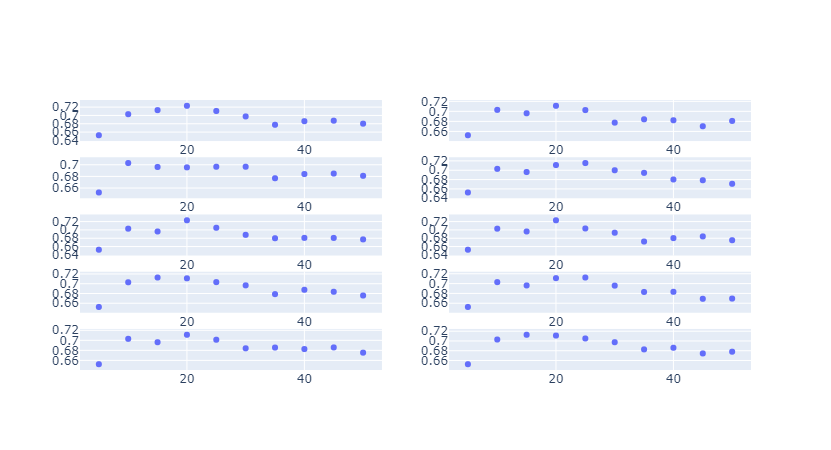

In [89]:
# plot
import plotly
from plotly.subplots import make_subplots
import plotly.express as px

# Use column names of df for the different parameters x, y, color, ...
fig1 = px.scatter(nmf_c, x="n_topics", y="iteration 0", 
                 title="NMF Coherence Score Tuning: Iteration 0",
                 labels={"iteration_0":"coherence Score", "n_topics": "number of topics"} # customize axis label
                )

fig2 = px.scatter(nmf_c, x="n_topics", y="iteration 1", 
                 title="NMF Coherence Score Tuning: Iteration 1",
                 labels={"iteration_1":"coherence Score", "n_topics": "number of topics"} # customize axis label
                )

fig3 = px.scatter(nmf_c, x="n_topics", y="iteration 2", 
                 title="NMF Coherence Score Tuning: Iteration 2",
                 labels={"iteration_2":"coherence Score", "n_topics": "number of topics"} # customize axis label
                )

fig4 = px.scatter(nmf_c, x="n_topics", y="iteration 3", 
                 title="NMF Coherence Score Tuning: Iteration 3",
                 labels={"iteration_3":"coherence Score", "n_topics": "number of topics"} # customize axis label
                )

fig5 = px.scatter(nmf_c, x="n_topics", y="iteration 4", 
                 title="NMF Coherence Score Tuning: Iteration 4",
                 labels={"iteration_4":"coherence Score", "n_topics": "number of topics"} # customize axis label
                )

fig6 = px.scatter(nmf_c, x="n_topics", y="iteration 5", 
                 title="NMF Coherence Score Tuning: Iteration 5",
                 labels={"iteration_5":"coherence Score", "n_topics": "number of topics"} # customize axis label
                )

fig7 = px.scatter(nmf_c, x="n_topics", y="iteration 6", 
                 title="NMF Coherence Score Tuning: Iteration 6",
                 labels={"iteration_6":"coherence Score", "n_topics": "number of topics"} # customize axis label
                )

fig8 = px.scatter(nmf_c, x="n_topics", y="iteration 7", 
                 title="NMF Coherence Score Tuning: Iteration 7",
                 labels={"iteration_7":"coherence Score", "n_topics": "number of topics"} # customize axis label
                )

fig9 = px.scatter(nmf_c, x="n_topics", y="iteration 8", 
                 title="NMF Coherence Score Tuning: Iteration 8",
                 labels={"iteration_8":"coherence Score", "n_topics": "number of topics"} # customize axis label
                )

fig10 = px.scatter(nmf_c, x="n_topics", y="iteration 9", 
                 title="NMF Coherence Score Tuning: Iteration 9",
                 labels={"iteration_9":"coherence Score", "n_topics": "number of topics"} # customize axis label
                )

fig = make_subplots(rows=5, cols=2)
fig.add_trace(fig1['data'][0], row=1, col=1)
fig.add_trace(fig2['data'][0], row=2, col=1)
fig.add_trace(fig3['data'][0], row=3, col=1)
fig.add_trace(fig4['data'][0], row=4, col=1)
fig.add_trace(fig5['data'][0], row=5, col=1)
fig.add_trace(fig6['data'][0], row=1, col=2)
fig.add_trace(fig7['data'][0], row=2, col=2)
fig.add_trace(fig8['data'][0], row=3, col=2)
fig.add_trace(fig9['data'][0], row=4, col=2)
fig.add_trace(fig10['data'][0], row=5, col=2)

fig.show()


# NMF

In [90]:
lim_docs = docs
len(lim_docs)

7933

In [91]:
# input needed for LDA, NMF (all from Scikit-Learn) is one string per document (not a list of strings)

text = []

for token_list in lim_docs:
    text.append(" ".join(token_list))

In [92]:
# Create a TF-IDF document-term matrix for the AI corpus 

# TRY DIFFERENT PARAMETERS IN THE TF-IDF DOC-TERM MATRIX SET-UP
nmf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=3, lowercase=True) #, max_features=int(len(lim_docs)/2))

# by default TfidfVectorizer has l2 normalization for rows: 
# from Scikit Learn documentation: Each output row will have unit norm, either: * ‘l2’: Sum of squares of vector 
# elements is 1. The cosine similarity between two vectors is their dot product when l2 norm has been applied.

nmf_tf_idf = nmf_vectorizer.fit_transform(text)

In [93]:
nmf_tf_idf.shape

(7933, 18390)

In [94]:
AI_terms = nmf_vectorizer.get_feature_names()

In [95]:
AI_terms[1:10]

['0005',
 '1000',
 '1000_genomes',
 '100x',
 '1024',
 '1025',
 '1086',
 '10_gy_x1',
 '10th']

In [96]:
# topic modeling with NMF

nmf_model = NMF(n_components=20, random_state=1)  # TRY DIFFERENT NUMBERS OF TOPICS
W = nmf_model.fit_transform(nmf_tf_idf)
H = nmf_model.components_

/home/dab3dj/.conda/envs/CO_BERT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



In [98]:
print_topics(nmf_model, nmf_vectorizer, 10)


Topic 0:
('algorithm', 2.099755432276108)
('learning', 1.7341719735298315)
('learn', 1.3126290520185717)
('machine_learning', 1.2649114049082557)
('theory', 0.9374122957947846)
('optimization', 0.9182058127687659)
('deep', 0.7803868767302005)
('statistical', 0.6836492138921091)
('machine', 0.6287708300684595)
('dimensional', 0.6207704730796446)

Topic 1:
('biology', 1.6235626637031961)
('computational', 1.415226042609516)
('bioinformatic', 0.6387485273081251)
('biological', 0.48088456295453996)
('trainee', 0.45611711424727697)
('biomedical', 0.42773322617443976)
('genomics', 0.4154995332392077)
('molecular', 0.35021383100739556)
('faculty', 0.33204171755306)
('facility', 0.2943357153000095)

Topic 2:
('neural', 2.377279842022444)
('brain', 2.2650571292119412)
('network', 1.4292342156307145)
('neuron', 1.2815096147637413)
('circuit', 0.6943919896963163)
('connectivity', 0.6548873644571049)
('cognitive', 0.5912725915177838)
('neuroscience', 0.5214943935454396)
('functional', 0.507919588

## hot and cold figure 

In [99]:
##### Extract Year from PROJECT_START_DATE

##### On our graphs, we want to be able to show year. Therefore, this getYear function gets the year from different date formats from Project Start Year/End Year
def getYear(a):   
    a = str(a)
    if a.find("/"):
        splitdate = a.split("/")
        if len(splitdate) == 3:
            a = splitdate[2]
        else:
            a = splitdate[0]
    year = str(a)
    return year

abstracts['START_YEAR'] = abstracts['PROJECT_START_DATE'].apply(getYear)

In [103]:
#Pulls sample data subsetted by year then takes mean theta for each abstract
num_topics=20

topic_frame = pd.DataFrame(W, columns=["Topic"+" "+str(i) for i in range(num_topics)])
topic_frame["START_YEAR"] = abstracts["START_YEAR"]

In [104]:
topic_frame.head()

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,...,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,START_YEAR
0,0.000000,0.051792,0.000000,0.000000,0.000742,0.000000,0.002655,0.000000,0.000000,0.000000,...,0.000000,0.002371,0.015153,0.178297,0.000000,0.000129,0.000019,0.000000,0.000000,2009
1,0.013670,0.000000,0.000000,0.000000,0.000000,0.048149,0.000382,0.000000,0.000000,0.000000,...,0.041984,0.002141,0.000000,0.030709,0.000000,0.000000,0.000993,0.002731,0.000000,2017
2,0.013088,0.000000,0.000000,0.000000,0.000000,0.047582,0.000000,0.000000,0.000000,0.000000,...,0.042014,0.002201,0.000000,0.030958,0.000000,0.000000,0.001072,0.002733,0.000000,2017
3,0.000000,0.001889,0.001528,0.001556,0.001740,0.005685,0.009266,0.002029,0.001205,0.002541,...,0.002297,0.003848,0.001019,0.003875,0.019347,0.000701,0.000927,0.000000,0.003393,2009
4,0.008070,0.005497,0.000000,0.000000,0.001049,0.008583,0.000728,0.000000,0.000000,0.000000,...,0.000000,0.003726,0.006715,0.000000,0.013402,0.000000,0.000016,0.001823,0.002061,2016


In [106]:
topic_proj_count = topic_frame.copy()
topic_count_bool = (topic_proj_count.iloc[:,0:num_topics] > 0)
topic_count_bool["START_YEAR"] = topic_proj_count["START_YEAR"]

In [108]:
topic_counts = topic_count_bool.groupby("START_YEAR").sum().reset_index()
topic_counts = topic_counts.sort_values(by = "START_YEAR")  # pretty sure this is unnecessary
topic_counts["START_YEAR"] = topic_counts["START_YEAR"].astype(int)

In [109]:
topic_counts_filt = topic_counts[topic_counts["START_YEAR"] > 2009] 
topic_counts_filt = topic_counts_filt[topic_counts_filt["START_YEAR"] < 2020]

In [111]:
# instances of topic in all years
n_by_topic = topic_counts_filt.sum()[1:]

In [113]:
topic_frame_se = topic_frame.groupby("START_YEAR").sem().reset_index()
topic_frame_se = topic_frame_se.sort_values(by = "START_YEAR")
topic_frame_se["START_YEAR"] = topic_frame_se["START_YEAR"].astype(int)

topic_wts_se_2010_2019 = topic_frame_se[topic_frame_se["START_YEAR"] > 2009] 
topic_wts_se_2010_2019 = topic_wts_se_2010_2019[topic_wts_se_2010_2019["START_YEAR"] < 2020]

In [114]:
topic_frame = topic_frame.groupby("START_YEAR").mean().reset_index()
topic_frame = topic_frame.sort_values(by = "START_YEAR")
topic_frame["START_YEAR"] = topic_frame["START_YEAR"].astype(int)

In [115]:
topic_wts_2010_2019 = topic_frame[topic_frame["START_YEAR"] > 2009] 
topic_wts_2010_2019 = topic_wts_2010_2019[topic_wts_2010_2019["START_YEAR"] < 2020] 

In [118]:
# perform regressions, track slopes

topic_slopes = []

for i in range(1,num_topics+1):
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,i].values.reshape(-1,1))
    
    topic_slopes.append(linear_fit.coef_[0][0])

In [119]:
hot_cold = []

for slope in topic_slopes:
    if slope > 0:
        hot_cold.append("hot")
    else:
        hot_cold.append("cold")

In [124]:
topic_words = str_topics(H, tfidf_vectorizer, top_n=10)

In [125]:
reg_topics = pd.DataFrame()
reg_topics["Slope"] = topic_slopes
reg_topics["Hot or Cold"] = hot_cold
reg_topics["Topic Words"] = topic_words 

In [127]:
leg = str_topics(H, tfidf_vectorizer, top_n=5)

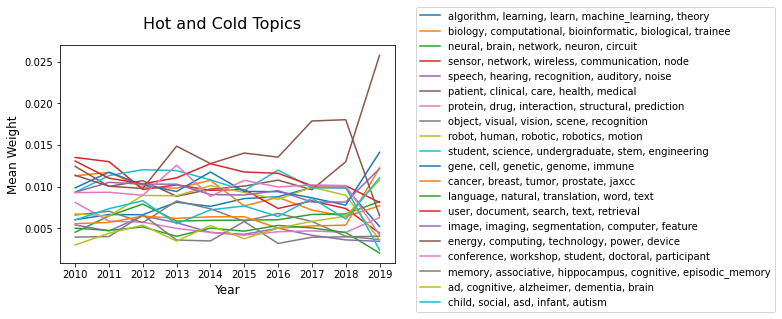

In [128]:
#Make Graphs
topic_results = {}
fig = plt.figure()
fig.suptitle('Hot and Cold Topics', fontsize=16)
ax = fig.add_subplot(111)

for i in range(1,num_topics+1):
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,i].values.reshape(-1,1))
    topic_results[i] = linear_fit.coef_[0][0]
    ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,i])
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=12)
plt.ylabel('Mean Weight', fontsize=12)
#ax.yaxis.set_label_coords(-0.14,0.5)
plt.legend(leg,bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
plt.show()

In [131]:
class HandlerDashedLines(HandlerLineCollection):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        # figure out how many lines there are
        numlines = len(orig_handle.get_segments())
        xdata, xdata_marker = self.get_xdata(legend, xdescent, ydescent,
                                             width, height, fontsize)
        leglines = []
        # divide the vertical space where the lines will go
        # into equal parts based on the number of lines
        ydata = np.full_like(xdata, height / (numlines + 1))
        # for each line, create the line at the proper location
        # and set the dash pattern
        for i in range(numlines):
            legline = Line2D(xdata, ydata * (numlines - i) - ydescent)
            self.update_prop(legline, orig_handle, legend)
            # set color, dash pattern, and linewidth to that
            # of the lines in linecollection
            try:
                color = orig_handle.get_colors()[i]
            except IndexError:
                color = orig_handle.get_colors()[0]
            try:
                dashes = orig_handle.get_dashes()[i]
            except IndexError:
                dashes = orig_handle.get_dashes()[0]
            try:
                lw = orig_handle.get_linewidths()[i]
            except IndexError:
                lw = orig_handle.get_linewidths()[0]
            if dashes[0] is not None:
                legline.set_dashes(dashes[1])
            legline.set_color(color)
            legline.set_transform(trans)
            legline.set_linewidth(lw)
            leglines.append(legline)
        return leglines

In [132]:
def sort_dict(x):
    return sorted(x.items(), key=lambda l: l[1], reverse=True)

In [133]:
sort_slopes = sort_dict(topic_results)
top_slopes = [x[0] for x in sort_slopes[:5]]
bottom_slopes = [x[0] for x in sort_slopes[-5:]]

In [134]:
# for plotting hot and cold on same graph

topnbot_slopes = top_slopes + bottom_slopes

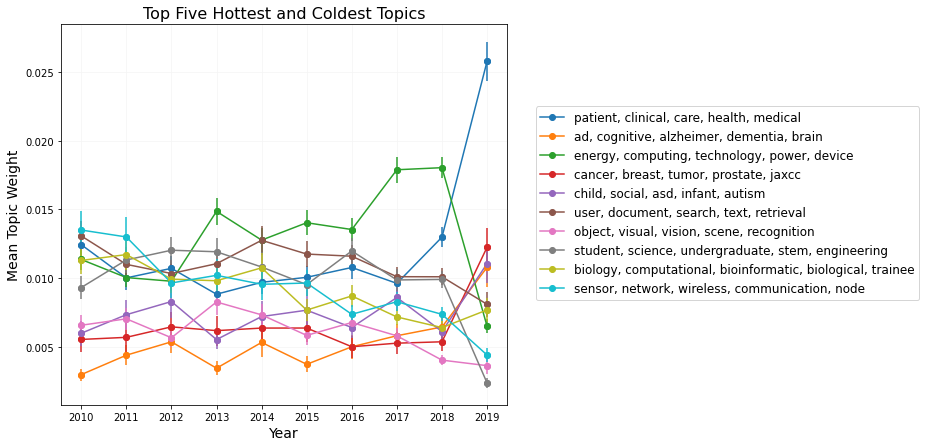

In [135]:
# Make Graphs
#leg = []
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']

#color_list = ["#232d4b","#2c4f6b","#0e879c","#60999a","#d1e0bf","#d9e12b","#e6ce3a","#e6a01d","#e57200", "#ff0000"] #"#fdfdfd"]


line_return = []
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111)
plt.grid(True, color = "whitesmoke")
line = [[(0, 0)]]
i = 0
for n in topnbot_slopes:
    zorder = 20
    color = color_list[i] 
    #if i < 5:
    #    zorder = 10 #10
    #    color = "#D3D3D3";
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,n].values.reshape(-1,1))
    #ax.plot(topic_wts_2010_2019["START_YEAR"], (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_,linestyle = 'dashed', color = color_list[i])
    ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], '-o', color = color, zorder = zorder)
    ax.errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], 
            yerr = np.array(topic_wts_se_2010_2019.iloc[:,n]), fmt = "o", color = color, zorder = zorder)
    #line_return.append(mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=[color_list[i],color_list[i]]))
    line_return.append(mcol.LineCollection(line, linestyles=['solid'], colors=[color]))
    i+=1
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=14)
plt.ylabel('Mean Topic Weight', fontsize=14)
#plt.ylim(bottom = -0.001, top = 0.05)
plt.title('Top Five Hottest and Coldest Topics', fontsize=16)
#ax.yaxis.set_label_coords(-0.14,0.5)

# set up the proxy artist
lc = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['blue','blue'])
lc2 = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['orange','orange'])

# create the legend
#plt.legend(line_return, [leg[x-1] for x in topnbot_slopes], handler_map={type(line_return[0]): HandlerDashedLines()})
           #handlelength=2, bbox_to_anchor=(1.05, 0.7, 0.3, 0.2), loc='upper left')  #handleheight=2,

plt.legend([leg[x-1] for x in topnbot_slopes], bbox_to_anchor=(1.05, 0.6, 0.3, 0.2), loc='upper left', fontsize = 'large')
#plt.savefig("figures/updated_full_hot_cold_topics.png", dpi = 800, bbox_inches = "tight")
plt.show()


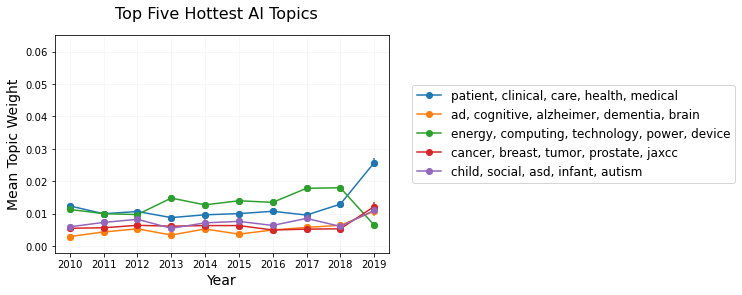

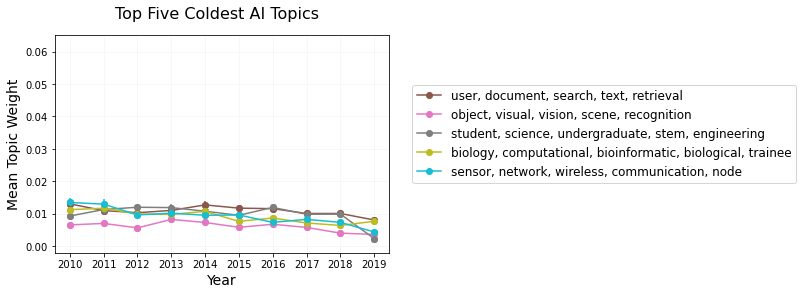

In [137]:
# Make Graphs
#leg = []
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']

#color_list = ["#232d4b","#2c4f6b","#0e879c","#60999a","#d1e0bf","#d9e12b","#e6ce3a","#e6a01d","#e57200", "#ff0000"] #"#fdfdfd"]
#color_list = ["#D3D3D3","#2c4f6b","#C0C0C0","#A9A9A9","#808080","#D3D3D3","#2c4f6b","#D3D3D3","#D3D3D3", "#D3D3D3"] #"#fdfdfd"]


line_return = []
fig = plt.figure()
fig.suptitle('Top Five Hottest AI Topics', fontsize=16)
ax = fig.add_subplot(111)
plt.grid(True, color = "whitesmoke")
line = [[(0, 0)]]
i = 0
for n in top_slopes:
    zorder = 10
    color = color_list[i] # "#D3D3D3"   
    if i == 0:
        zorder = 10 #20
        color = color_list[i];
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,n].values.reshape(-1,1))
    #ax.plot(topic_wts_2010_2019["START_YEAR"], (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_,linestyle = 'dashed', color = color_list[i])
    ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], '-o', color = color, zorder = zorder)
    ax.errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], 
            yerr = np.array(topic_wts_se_2010_2019.iloc[:,n]), fmt = "o", color = color, zorder = zorder)
    #line_return.append(mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=[color_list[i],color_list[i]]))
    line_return.append(mcol.LineCollection(line, linestyles=['solid'], colors=[color]))
    i+=1
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=14)
plt.ylabel('Mean Topic Weight', fontsize=14)
plt.ylim(bottom = -0.002, top = 0.065)
#ax.yaxis.set_label_coords(-0.14,0.5)

# set up the proxy artist
lc = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['blue','blue'])
lc2 = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['orange','orange'])
# create the legend
#plt.legend(line_return, [leg[x-1] for x in top_slopes], handler_map={type(line_return[0]): HandlerDashedLines()},
#          handlelength=2, handleheight=2,bbox_to_anchor=(1.05, 0.7, 0.3, 0.2), loc='upper left')

plt.legend([leg[x-1] for x in top_slopes], bbox_to_anchor=(1.05, 0.6, 0.3, 0.2), loc='upper left', fontsize = 'large')
#plt.savefig("figures/coronavirus_hot_topics-new.png", dpi = 800, bbox_inches = "tight")
plt.show()


#Make Graphs
#leg = []

#bottom_slopes.reverse()  # so the plot legend has the coldest listed first

line_return = []
fig = plt.figure()
fig.suptitle('Top Five Coldest AI Topics', fontsize=16)
ax = fig.add_subplot(111)
plt.grid(True, color = "whitesmoke")
i = 0
for n in bottom_slopes:
    zorder = 10
    color = color_list[i+5]  #"#D3D3D3"  
    if i == 4:
        zorder = 10 #20
        color = color_list[i+5]
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,n].values.reshape(-1,1))
    #ax.plot(topic_wts_2010_2019["START_YEAR"], (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_,linestyle = 'dashed', color = color_list[i+5])
    ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], '-o', color=color, zorder = zorder)
    ax.errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], 
            yerr = np.array(topic_wts_se_2010_2019.iloc[:,n]), fmt = "o", color=color, zorder = zorder)
    #line_return.append(mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=[color_list[i+5],color_list[i+5]]))
    line_return.append(mcol.LineCollection(line, linestyles=['solid'], colors=[color]))
    i+=1
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=14)
plt.ylabel('Mean Topic Weight', fontsize=14)
plt.ylim(bottom = -0.002, top = 0.065)
#ax.yaxis.set_label_coords(-0.14,0.5)


# set up the proxy artist
lc = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['blue','blue'])
lc2 = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['orange','orange'])

# create the legend
#plt.legend(line_return, [leg[x-1] for x in bottom_slopes], handler_map={type(line_return[0]): HandlerDashedLines()},
#          handlelength=2, handleheight=2,bbox_to_anchor=(1.05, 0.7, 0.3, 0.2), loc='upper left')

plt.legend([leg[x-1] for x in bottom_slopes], bbox_to_anchor=(1.05, 0.6, 0.3, 0.2), loc='upper left', fontsize = 'large')
#plt.savefig("figures/coronavirus_cold_topics-new.png", dpi = 800, bbox_inches = "tight")
plt.show()
